In [6]:
# Hour 4 – Baseline Linear Model + Residual Analysis

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# --- Load + Flatten Data ---
with open("public_cases.json") as f:
    raw = json.load(f)

df = pd.json_normalize([case["input"] for case in raw])
df["expected_output"] = [case["expected_output"] for case in raw]

# --- Baseline Features ---
X_base = df[["miles_traveled", "trip_duration_days", "total_receipts_amount"]]
y = df["expected_output"]

# --- Baseline Linear Regression ---
model = LinearRegression()
model.fit(X_base, y)
df["baseline_pred"] = model.predict(X_base)

# --- Error Metrics ---
mae = mean_absolute_error(y, df["baseline_pred"])
rmse = np.sqrt(mean_squared_error(y, df["baseline_pred"]))
print(f"📈 Baseline Linear Model — MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# --- Residuals ---
df["abs_error"] = np.abs(df["baseline_pred"] - y)
worst_cases = df.sort_values("abs_error", ascending=False).head(10)

# --- Output Table of Top Errors ---
print("\n🔎 Top 10 Worst Predictions:")
print(worst_cases[["miles_traveled", "trip_duration_days", "total_receipts_amount", "expected_output", "baseline_pred", "abs_error"]])

# --- Optional: Log-Transform Variant ---
log_transform = Pipeline([
    ("log", FunctionTransformer(np.log1p)),
    ("reg", LinearRegression())
])
log_transform.fit(X_base, y)
df["log_pred"] = log_transform.predict(X_base)

log_mae = mean_absolute_error(y, df["log_pred"])
log_rmse = np.sqrt(mean_squared_error(y, df["log_pred"]))
print(f"\n🔁 Log-Transform Model — MAE: {log_mae:.2f}, RMSE: {log_rmse:.2f}")


📈 Baseline Linear Model — MAE: 175.49, RMSE: 218.48

🔎 Top 10 Worst Predictions:
     miles_traveled  trip_duration_days  total_receipts_amount  \
151            69.0                   4                2321.49   
995          1082.0                   1                1809.49   
683           795.0                   8                1645.99   
710           516.0                   5                1878.49   
547           482.0                   8                1411.49   
148          1006.0                   7                1181.33   
512          1025.0                   8                1031.33   
366           740.0                  11                1171.99   
519           481.0                  14                 939.99   
668          1033.0                   7                1013.03   

     expected_output  baseline_pred    abs_error  
151           322.00    1386.466583  1064.466583  
995           446.94    1491.729090  1044.789090  
683           644.69    1651.584561  10

In [12]:

def rule_based_predict(row):
    # --- Base Per Diem ---
    days = row["trip_duration_days"]
    if days >= 14:
        per_diem_rate = 85
    elif days == 5:
        per_diem_rate = 100 * 1.05  # 5% bonus for exactly 5 days
    else:
        per_diem_rate = 100
    per_diem_total = per_diem_rate * days

    # --- Mileage Calculation ---
    miles = row["miles_traveled"]
    if miles <= 100:
        mileage_rate = 0.58
    elif miles <= 600:
        mileage_rate = 0.58 - 0.12 * np.log10(miles / 100)
    else:
        mileage_rate = 0.36
    mileage_total = mileage_rate * miles

    # --- Receipt Bonus / Cap ---
    receipts = min(row["total_receipts_amount"], 1800)
    if receipts < 50:
        receipt_bonus = -0.10
    elif receipts <= 600:
        receipt_bonus = 0.08
    elif receipts <= 1800:
        receipt_bonus = 0.03
    else:
        receipt_bonus = 0

    # --- Efficiency Bonus / Penalty (MPD) ---
    mpd = miles / days if days > 0 else 0
    if 180 <= mpd <= 220:
        efficiency_bonus = 0.07
    elif mpd < 80:
        efficiency_bonus = -0.05
    elif mpd > 300:
        efficiency_bonus = -0.04
    else:
        efficiency_bonus = 0

    base_reimb = per_diem_total + mileage_total
    adjusted_reimb = base_reimb * (1 + receipt_bonus + efficiency_bonus)

    return adjusted_reimb

In [13]:
df["rule_pred"] = df.apply(rule_based_predict, axis=1)
rule_mae = mean_absolute_error(df["expected_output"], df["rule_pred"])
rule_rmse = np.sqrt(mean_squared_error(df["expected_output"], df["rule_pred"]))

print(f"📏 Rule-Based Model — MAE: {rule_mae:.2f}, RMSE: {rule_rmse:.2f}")


📏 Rule-Based Model — MAE: 476.88, RMSE: 565.59


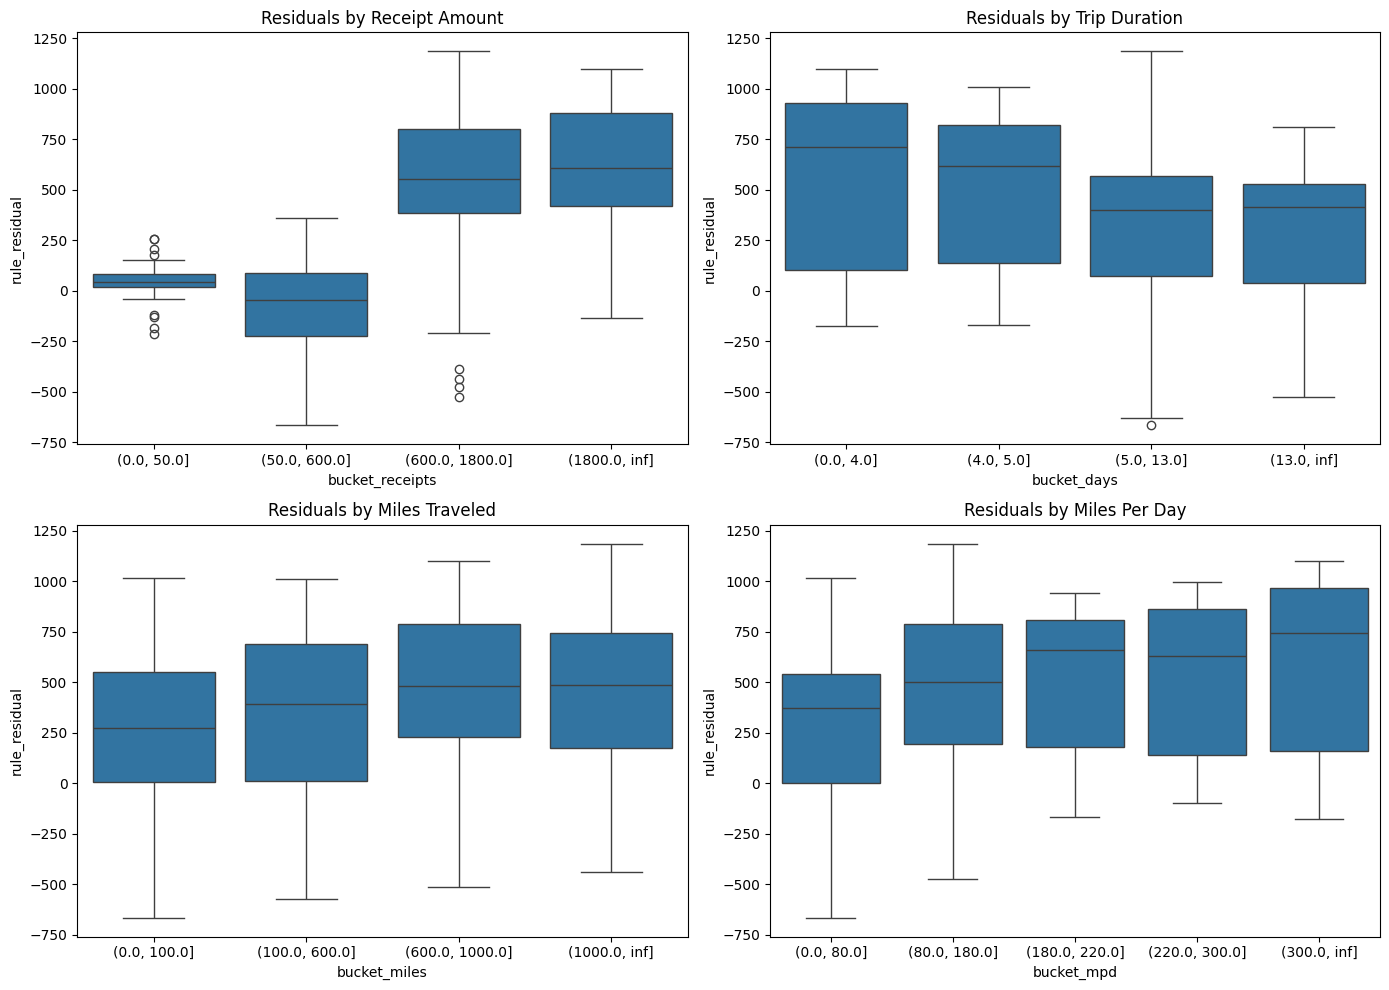

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Residuals ---
df["rule_residual"] = df["expected_output"] - df["rule_pred"]
df["abs_error"] = df["rule_residual"].abs()

# --- Bucketing Inputs ---
df["bucket_receipts"] = pd.cut(df["total_receipts_amount"], bins=[0, 50, 600, 1800, np.inf])
df["bucket_days"] = pd.cut(df["trip_duration_days"], bins=[0, 4, 5, 13, np.inf])
df["bucket_miles"] = pd.cut(df["miles_traveled"], bins=[0, 100, 600, 1000, np.inf])
df["mpd"] = df["miles_traveled"] / df["trip_duration_days"].clip(lower=1)
df["bucket_mpd"] = pd.cut(df["mpd"], bins=[0, 80, 180, 220, 300, np.inf])

# --- Visual Residual Hunt ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=df, x="bucket_receipts", y="rule_residual", ax=axs[0, 0])
axs[0, 0].set_title("Residuals by Receipt Amount")

sns.boxplot(data=df, x="bucket_days", y="rule_residual", ax=axs[0, 1])
axs[0, 1].set_title("Residuals by Trip Duration")

sns.boxplot(data=df, x="bucket_miles", y="rule_residual", ax=axs[1, 0])
axs[1, 0].set_title("Residuals by Miles Traveled")

sns.boxplot(data=df, x="bucket_mpd", y="rule_residual", ax=axs[1, 1])
axs[1, 1].set_title("Residuals by Miles Per Day")

plt.tight_layout()
plt.show()


In [16]:
def rule_based_predict_v2(row):
    # --- Base Per Diem ---
    days = row["trip_duration_days"]
    if days >= 14:
        per_diem_rate = 85
    elif days == 5:
        per_diem_rate = 100 * 1.05
    else:
        per_diem_rate = 100
    per_diem_total = per_diem_rate * days

    # --- Mileage ---
    miles = row["miles_traveled"]
    if miles <= 100:
        mileage_rate = 0.58
    elif miles <= 600:
        mileage_rate = 0.58 - 0.12 * np.log10(miles / 100)
    else:
        mileage_rate = 0.36
    mileage_total = mileage_rate * miles

    # --- Receipts ---
    receipts = min(row["total_receipts_amount"], 1800)
    receipts_per_day = receipts / days if days > 0 else 0

    if receipts < 50:
        receipt_bonus = -0.10
    elif receipts <= 600:
        receipt_bonus = 0.10  # ↑ boosted from 0.08
    elif receipts <= 1800:
        receipt_bonus = 0.03
    else:
        receipt_bonus = 0

    # --- Efficiency Bonus (MPD) ---
    mpd = miles / days if days > 0 else 0
    if 180 <= mpd <= 220:
        efficiency_bonus = 0.12   # ↑ from 0.07
    elif mpd < 80:
        efficiency_bonus = -0.08  # ↑ from -0.05
    elif mpd > 300:
        efficiency_bonus = -0.06  # ↑ from -0.04
    else:
        efficiency_bonus = 0

    base_reimb = per_diem_total + mileage_total
    bonus = 0

    # --- Layered Bonuses ---
    bonus += receipt_bonus
    bonus += efficiency_bonus

    # --- Interaction: Jackpot Combo ---
    if days == 5 and 180 <= mpd <= 220 and receipts_per_day <= 100:
        bonus += 0.12  # “5-day efficiency combo”

    # --- Interaction: Vacation Penalty ---
    if days >= 8 and receipts_per_day >= 120:
        bonus -= 0.15  # “vacation penalty”

    # --- High-Spend Cliff ---
    if row["total_receipts_amount"] > 1800:
        bonus -= 0.05  # Extra post-cap penalty

    return base_reimb * (1 + bonus)


In [17]:
df["rule_pred_v2"] = df.apply(rule_based_predict_v2, axis=1)
mae_v2 = mean_absolute_error(df["expected_output"], df["rule_pred_v2"])
rmse_v2 = np.sqrt(mean_squared_error(df["expected_output"], df["rule_pred_v2"]))
print(f"📏 Rule-Based Model v2 — MAE: {mae_v2:.2f}, RMSE: {rmse_v2:.2f}")


📏 Rule-Based Model v2 — MAE: 544.85, RMSE: 635.26


In [19]:
def rule_based_predict_v2_1(row):
    # --- Base Per Diem ---
    days = row["trip_duration_days"]
    if days >= 14:
        per_diem_rate = 85
    elif days == 5:
        per_diem_rate = 100 * 1.05
    else:
        per_diem_rate = 100
    per_diem_total = per_diem_rate * days

    # --- Mileage ---
    miles = row["miles_traveled"]
    if miles <= 100:
        mileage_rate = 0.58
    elif miles <= 600:
        mileage_rate = 0.58 - 0.12 * np.log10(miles / 100)
    else:
        mileage_rate = 0.36
    mileage_total = mileage_rate * miles

    # --- Receipts (v1 logic only) ---
    receipts = min(row["total_receipts_amount"], 1800)
    if receipts < 50:
        receipt_bonus = -0.10
    elif receipts <= 600:
        receipt_bonus = 0.08
    elif receipts <= 1800:
        receipt_bonus = 0.03
    else:
        receipt_bonus = 0

    # --- Efficiency Bonus (MPD only) ---
    mpd = miles / days if days > 0 else 0
    if 180 <= mpd <= 220:
        efficiency_bonus = 0.07
    elif mpd < 80:
        efficiency_bonus = -0.05
    elif mpd > 300:
        efficiency_bonus = -0.04
    else:
        efficiency_bonus = 0

    base_reimb = per_diem_total + mileage_total
    total_bonus = receipt_bonus + efficiency_bonus

    return base_reimb * (1 + total_bonus)


In [20]:
df["rule_pred_v2_1"] = df.apply(rule_based_predict_v2_1, axis=1)
mae = mean_absolute_error(df["expected_output"], df["rule_pred_v2_1"])
rmse = np.sqrt(mean_squared_error(df["expected_output"], df["rule_pred_v2_1"]))
print(f"📏 Rule-Based Model v2.1 — MAE: {mae:.2f}, RMSE: {rmse:.2f}")


📏 Rule-Based Model v2.1 — MAE: 476.88, RMSE: 565.59


In [24]:
# Jackpot Rule (from Kevin):
# If days == 5 and 180 ≤ miles/days ≤ 220 and receipts/day ≤ 100, apply +12% bonus

def rule_based_predict_v2_1(row):
    
    # --- Base Per Diem ---
    days = row["trip_duration_days"]
    if days >= 14:
        per_diem_rate = 85
    elif days == 5:
        per_diem_rate = 100 * 1.05
    else:
        per_diem_rate = 100
    per_diem_total = per_diem_rate * days

    # --- Mileage ---
    miles = row["miles_traveled"]
    if miles <= 100:
        mileage_rate = 0.58
    elif miles <= 600:
        mileage_rate = 0.58 - 0.12 * np.log10(miles / 100)
    else:
        mileage_rate = 0.36
    mileage_total = mileage_rate * miles

    # --- Receipts (v1 logic only) ---
    receipts = min(row["total_receipts_amount"], 1800)
    if receipts < 50:
        receipt_bonus = -0.10
    elif receipts <= 600:
        receipt_bonus = 0.08
    elif receipts <= 1800:
        receipt_bonus = 0.03
    else:
        receipt_bonus = 0

    # --- Efficiency Bonus (MPD only) ---
    mpd = miles / days if days > 0 else 0
    if 180 <= mpd <= 220:
        efficiency_bonus = 0.07
    elif mpd < 80:
        efficiency_bonus = -0.05
    elif mpd > 300:
        efficiency_bonus = -0.04
    else:
        efficiency_bonus = 0

    base_reimb = per_diem_total + mileage_total
    total_bonus = receipt_bonus + efficiency_bonus
    adjusted_reimb = base_reimb * (1 + total_bonus)

    # --- Jackpot Combo Bonus ---
    daily_receipts = receipts / days if days > 0 else 0
    if days == 5 and 180 <= mpd <= 220 and daily_receipts <= 100:
        adjusted_reimb *= 1.12  # +12% jackpot bonus
        
    return base_reimb * (1 + total_bonus)


In [25]:
df["rule_pred_v2_1"] = df.apply(rule_based_predict_v2_1, axis=1)
mae = mean_absolute_error(df["expected_output"], df["rule_pred_v2_1"])
rmse = np.sqrt(mean_squared_error(df["expected_output"], df["rule_pred_v2_1"]))
print(f"📏 Rule-Based Model v2.1 — MAE: {mae:.2f}, RMSE: {rmse:.2f}")


📏 Rule-Based Model v2.1 — MAE: 476.88, RMSE: 565.59
